In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/301_project



/content/drive/.shortcut-targets-by-id/1MYdHZqeVKSuQzIzZWrfBqMgi2EgY91a0/301_project


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:

val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [ ]:
train_texts[0]

'This is a dumb movie. Maybe my judgment wouldn\'t be so harsh if the film didn\'t promise so much, but I just felt like this movie cheated and played me for a fool at every turn.<br /><br />I didn\'t have any beef with the acting, but I thought the characters were awful. The movie starts off with Clive Owen\'s character telling us what a criminal mastermind he is, and how he planned the perfect bank robbery, something he frequently reminds us of later. Oh yeah, he also tells us he\'s in a prison cell, although that turns out to be a dumb metaphor. Any idiot knows that the best bank robbery is one where a minimum number of things could potentially go wrong, and you\'re long gone before the police show up. But Clive Owen\'s scheme requires hanging around the bank for hours - for no reason but to stalk around and look scary as far as I can tell. He also has to control hostages, negotiate with cops, and most fantastically of all, perform a This-Old-House job on the bank\'s stockroom and h

# cleaning

In [ ]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# turn a doc into clean tokens
def clean_doc(data):
  preprocessed_data = []
  for doc in data:
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)

    preprocessed_data.append(tokens)

  return preprocessed_data

In [ ]:
trainX = clean_doc(train_texts)
valX = clean_doc(val_texts)
testX=clean_doc(test_texts)

# bag of words


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [ ]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
length = max_length(trainX)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trainX = encode_text(tokenizer, trainX, length)
valX = encode_text(tokenizer, valX, length)
testX = encode_text(tokenizer, testX, length)
print(trainX.shape)

Max document length: 1480
Vocabulary size: 142960
(35000, 1480)


# define model

In [ ]:

from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers

In [ ]:
# define the model
def define_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	plot_model(model, show_shapes=True, to_file='multichannel.png')
	return model

In [ ]:
# define model
model = define_model(length, vocab_size)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1480)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1480, 100)    14296000    ['input_1[0][0]']                
                                                                                              

In [ ]:
import tensorflow as tf

In [ ]:
# callback
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './mc_base/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)



In [ ]:
from datetime import datetime

## 1st 10 epochs

In [ ]:
start = datetime.now()

history = model.fit([trainX,trainX,trainX], array(train_labels.tolist()),
          batch_size=128,
          validation_data=([valX,valX,valX], array(val_labels.tolist())),
          epochs=10,
          callbacks=[PrintingCallback(), model_checkpoint_callback])

end = datetime.now()

print('time: ',end-start)

print(history.history.keys())

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7629The average loss for epoch 0 is    0.28 and accuracy is    0.89.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.88879, saving model to ./mc_base/checkpoint
274/274 [==============================] - 42s 97ms/step - loss: 0.4454 - accuracy: 0.7629 - val_loss: 0.2781 - val_accuracy: 0.8888
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9515The average loss for epoch 1 is    0.26 and accuracy is    0.89.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.88879 to 0.89065, saving model to ./mc_base/checkpoint
274/274 [==============================] - 26s 95ms/step - loss: 0.1358 - accuracy: 0.9515 - val_loss: 0.2650 - val_accuracy: 0.8907
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9917The average loss for epoch 2 is    0.32 and accuracy is    0.88.
LR is: 0.001

Epoch 3: val_accuracy did not

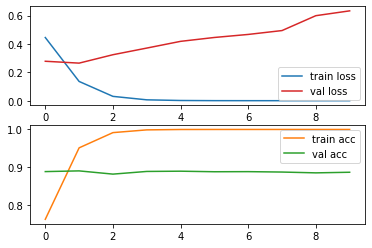

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX],array(test_labels.tolist()), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 88.798505


In [ ]:
# evaluate model on test dataset dataset from best check point
model.load_weights(checkpoint_filepath)

loss, acc = model.evaluate([testX,testX,testX],array(test_labels.tolist()), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 89.971995


# 20 mroe epochs

In [ ]:
model.load_weights(checkpoint_filepath)

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

start = datetime.now()

history_2 = model.fit([trainX,trainX,trainX], array(train_labels.tolist()),
          batch_size=128,
          validation_data=([valX,valX,valX], array(val_labels.tolist())),
          epochs=10,
          callbacks=[PrintingCallback(), model_checkpoint_callback])

end = datetime.now()

print('time: ',end-start)



Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9876The average loss for epoch 0 is    0.33 and accuracy is    0.89.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.89065
274/274 [==============================] - 25s 88ms/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.3334 - val_accuracy: 0.8856
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9986The average loss for epoch 1 is    0.41 and accuracy is    0.89.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.89065
274/274 [==============================] - 24s 88ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.4064 - val_accuracy: 0.8853
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999The average loss for epoch 2 is    0.45 and accuracy is    0.88.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.89065
274/274 [==============================] - 24s 89ms/step - 

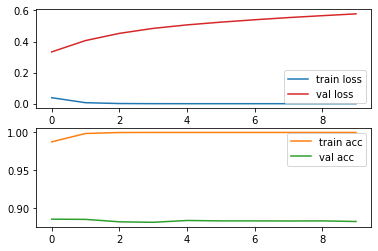

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history_2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history_2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history_2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history_2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
# save the model
model.save('m2.h5')


In [ ]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX],array(test_labels.tolist()), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 88.505137


In [ ]:
# evaluate model on test dataset dataset from best check point
model.load_weights(checkpoint_filepath)

loss, acc = model.evaluate([testX,testX,testX],array(test_labels.tolist()), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 89.971995
